# Are SAT's racist? - does the data indicate inequality within SAT's.

Scholastic assesment tests (SAT's) are a key step in many Americans academic lives. Your score on your SAT's can dramatically affect your choice of collage, scholarship opportunities, and potentially career paths. Because of this, it is important that this test fairly measures students abilities regardless of racial or socio-economic background.

In this project I will be investigating how racial and socio-economic dynamics may impact SAT scores, and whether the current system is unfair for particular groups. Once my analysis is complete, I shall suggest a course of action based on the results.

## Part 1: Reading in libraries and cleaning the data

In [26]:

#Libraries

import pandas as pd
import numpy
import re
import matplotlib.pyplot as plt

#Reading in data file as a dictionary
data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]
data = {}

for f in data_files:
    key_name = f.replace(".csv", "")
    d = pd.read_csv(f"schools/{f}")
    data[key_name] = d

In [3]:
#Reading in survey data seperately due to a different kind of encoding
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey = survey.copy()
survey["DBN"] = survey["dbn"]

#isolating relevant columns
survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
    
]
survey = survey[survey_fields]
data["survey"] = survey

# Add DBN columns

In [4]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [5]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [6]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg('mean', numeric_only=True)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [7]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [8]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean(numeric_only=True))
combined = combined.infer_objects(copy=False).fillna(0)

# Add a school district column for mapping

In [9]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined = combined.copy()
combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [10]:
correlations = combined.corr(numeric_only=True)
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


# Plotting survey correlations

In [11]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

## Part 2:Investigating survey data




Text(0, 0.5, 'relevant column')

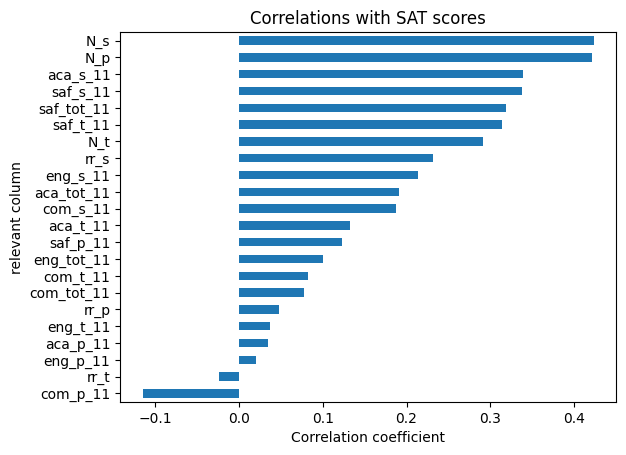

In [13]:
corr = combined.corr(numeric_only = True)

corr_cleaned = corr["sat_score"]

corr_cleaned_survey = corr_cleaned[survey_fields]

corr_cleaned_survey = corr_cleaned_survey.sort_values(ascending= True)

corr_cleaned_survey.plot.barh()
plt.title( "Correlations with SAT scores")
plt.xlabel("Correlation coefficient")
plt.ylabel("relevant column")

From looking at the above graph, there are some interesting factors correlating with SAT score.

Firstly, the number of student(N_s) and parent responses(N_p) correlate well with SAT score, this might indicate that classes that are doing well are more likely to engage in these surveys.

the column "aca_s_11", in which highlights academic expectations based on student responses, also has a high correlation. This is expected as students with higher academic outcomes would tend to have higher SAT scores.

Three interesting correlations are "saf_s_11","saf_t_11", and "saf_tot_11". These relate to feelings of safety within school for the students, teachers and in total. This would suggest that the safety of students and teachers are a key factor in teaching effectively.  This makes sense, teachers who aren't worried are good teachers, likewise with students. Furthermore,  students with violent tendencies may not do well at school. 

It was also that found that communication scores based on parent responses had a negative correlation on sat scores. from this we can  deduce that increased communications are probably for students going through difficulties, who may not be as prepared for the SAT test.

As safety is a key concern, let's have investigate the student safety column in more granular detail.



Text(0.5, 1.0, 'How does percieved student safety affect SAT scores?')

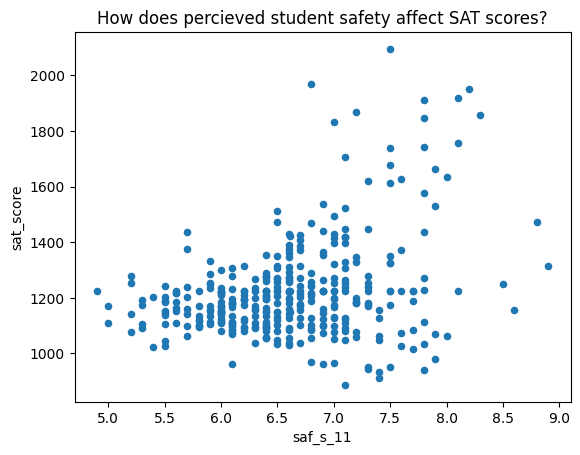

In [14]:
#Scatter plot for student safety based on survey responses
combined.plot.scatter(y = "sat_score", x= "saf_s_11")
plt.title("How does percieved student safety affect SAT scores?")

From this data, we can see that although there's not a very strong correlation between safety and sat scores, however it seems that increased safety may allow students who are academically gifted to do better on their tests. Next, let's have a look at school safety by borough.

## Part 3: Investigating SAT scores by location

In [15]:

#Creating a borough column by grouping the relevant districts together.
pattern_manhattan= r"0[123456]"
pattern_bronx = r"0[789]|1[012]"
pattern_brooklyn = r"1[3456789]|2[0123]|32"
pattern_queens= r"2[456789]|30"
pattern_staten =  r"31"

manhattan_bool = combined["school_dist"].str.contains(pattern_manhattan)
bronx_bool = combined["school_dist"].str.contains(pattern_bronx)
brooklyn_bool = combined["school_dist"].str.contains(pattern_brooklyn)
queens_bool = combined["school_dist"].str.contains(pattern_queens)
staten_bool = combined["school_dist"].str.contains(pattern_staten)

combined["borough"] = "placeholder"

combined.loc[manhattan_bool, "borough"] = "manhattan"
combined.loc[bronx_bool, "borough"] = "bronx"
combined.loc[brooklyn_bool, "borough"] = "brooklyn"
combined.loc[queens_bool, "borough"] = "queens"
combined.loc[staten_bool, "borough"] = "staten"

In [16]:
grouped_borough = combined.groupby("borough")["saf_s_11"].agg("mean")
grouped_borough

borough
bronx        6.606577
brooklyn     6.370755
manhattan    6.831370
queens       6.721875
staten       6.530000
Name: saf_s_11, dtype: float64

Looking at the above data, we can see that by borough safety scores are not significantly different, which would suggest every borough has safe and unsafe schools. Let's investigate at the more granular level and go by district.

In [ ]:
combined.groupby("school_dist")["saf_s_11"].agg("mean").sort_values(ascending = False)

From the above values, we can see that between there is a significant difference between the safest school districts and the most dangerous. This suggests that school safety is more of a wider New York issue than a particular borough. From a brief look on the US government website, we can see that many districts with a low safety score also have low median income. This would suggest that low income areas has less safe schools, which lead to lower SAT scores.

Next, let us investigate racial dynamics with SAT scores.

## Part 4: Investigating SAT scores by racial group

In [18]:
#Isolating relevant racial columns
race_sat = combined[["white_per","asian_per", "black_per", "hispanic_per", "sat_score"]]


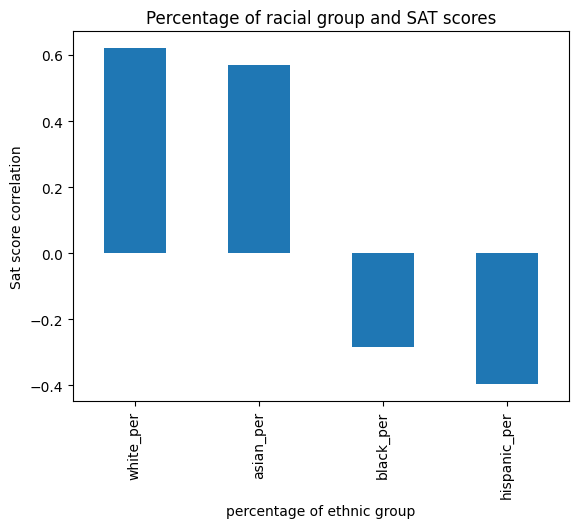

In [19]:
#correlation between race and SAT's
race_sat_corr = race_sat.corr()["sat_score"][:-1]

#barplot for correlation
race_sat_corr.plot.bar()
plt.ylabel("Sat score correlation")
plt.xlabel("percentage of ethnic group")
plt.title("Percentage of racial group and SAT scores")
plt.show()

From the above graph we can see that a higher black and hispanic percentage in schools is correlated with a lower SAT score, whilst a higher white or asian percentage in schools is correlated with a higher SAT score. Let's investigate these trends at a more granular level.

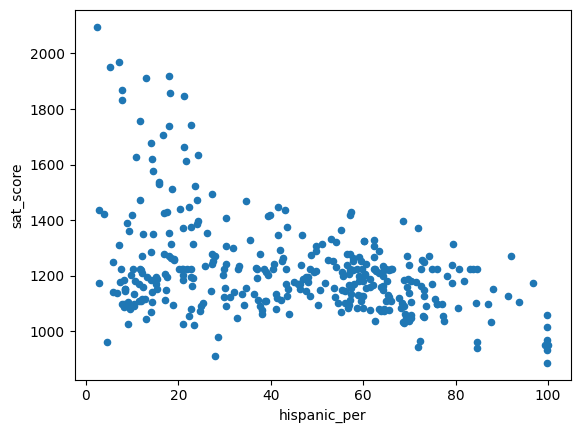

In [20]:
#scatter plot for hispanic percentage
combined.plot.scatter(x= "hispanic_per", y= "sat_score")
plt.show()

From the above graph, we can see somewhat of a correlation, particularly after 30%, in which SAT_scores do not go above 1600. Let's have a look at schools where the vast majority of students are hispanic.

In [21]:
combined[combined["hispanic_per"] > 95]

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist,borough
44,02M542,MANHATTAN BRIDGES HIGH SCHOOL,66,336.0,378.0,344.0,1058.0,Manhattan Bridges High School,67.000000,102.000000,...,0,0,0.0,0.0,0.0,"525 West 50Th Street\nNew York, NY 10019\n(40....",40.765027,-73.992517,02,manhattan
82,06M348,WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL,70,380.0,395.0,399.0,1174.0,0,129.028846,197.038462,...,0,0,0.0,0.0,0.0,"511 West 182Nd Street\nNew York, NY 10033\n(40...",40.848879,-73.930807,06,manhattan
89,06M552,GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...,56,339.0,349.0,326.0,1014.0,GREGORIO LUPERON HS SCI & MATH,88.000000,138.000000,...,0,0,0.0,0.0,0.0,"501 West 165Th\nNew York, NY 10032\n(40.838032...",40.838032,-73.938371,06,manhattan
125,09X365,ACADEMY FOR LANGUAGE AND TECHNOLOGY,54,315.0,339.0,297.0,951.0,Academy for Language and Technology,20.000000,20.000000,...,0,0,0.0,0.0,0.0,"1700 Macombs Road\nBronx, NY 10453\n(40.849102...",40.849102,-73.916088,09,bronx
141,10X342,INTERNATIONAL SCHOOL FOR LIBERAL ARTS,49,300.0,333.0,301.0,934.0,International School for Liberal Arts,55.000000,73.000000,...,0,0,0.0,0.0,0.0,"2780 Reservoir Avenue\nBronx, NY 10468\n(40.87...",40.870377,-73.898163,10,bronx
176,12X388,PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE,30,321.0,351.0,298.0,970.0,0,129.028846,197.038462,...,0,0,0.0,0.0,0.0,"1300 Boynton Avenue\nBronx, NY 10472\n(40.8313...",40.831366,-73.878823,12,bronx
253,19K583,MULTICULTURAL HIGH SCHOOL,29,279.0,322.0,286.0,887.0,Multicultural High School,44.000000,44.000000,...,0,0,0.0,0.0,0.0,"999 Jamaica Avenue\nBrooklyn, NY 11208\n(40.69...",40.691144,-73.868426,19,brooklyn
286,24Q296,PAN AMERICAN INTERNATIONAL HIGH SCHOOL,55,317.0,323.0,311.0,951.0,0,129.028846,197.038462,...,0,0,0.0,0.0,0.0,"45-10 94Th Street\nElmhurst, NY 11373\n(40.743...",40.743303,-73.870575,24,queens


Looking at the above table, schools with a high hispanic population tend to be international schools

In [22]:
low_hisp_high_sat = combined[(combined["hispanic_per"] < 10) & (combined["sat_score"] > 1800)]
low_hisp_high_sat

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist,borough
37,02M475,STUYVESANT HIGH SCHOOL,832,679.0,735.0,682.0,2096.0,STUYVESANT HS,1510.0,2819.0,...,0,0,0.0,0.0,0.0,"345 Chambers Street\nNew York, NY 10282\n(40.7...",40.717746,-74.014049,02,manhattan
151,10X445,BRONX HIGH SCHOOL OF SCIENCE,731,632.0,688.0,649.0,1969.0,BRONX HS OF SCIENCE,1190.0,2435.0,...,0,0,0.0,0.0,0.0,"75 West 205 Street\nBronx, NY 10468\n(40.87705...",40.877056,-73.889780,10,bronx
187,13K430,BROOKLYN TECHNICAL HIGH SCHOOL,1277,587.0,659.0,587.0,1833.0,BROOKLYN TECHNICAL HS,2117.0,3692.0,...,0,0,0.0,0.0,0.0,"29 Ft Greene Place\nBrooklyn, NY 11217\n(40.68...",40.688107,-73.976745,13,brooklyn
327,28Q687,QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...,121,612.0,660.0,596.0,1868.0,Queens HS for Science York Colllege,215.0,338.0,...,0,0,0.0,0.0,0.0,"94-50 159 Street\nJamaica, NY 11433\n(40.70099...",40.700999,-73.798154,28,queens
356,31R605,STATEN ISLAND TECHNICAL HIGH SCHOOL,227,635.0,682.0,636.0,1953.0,STATEN ISLAND TECHNICAL HS,528.0,905.0,...,0,0,0.0,0.0,0.0,"485 Clawson Street\nStaten Island, NY 10306\n(...",40.567913,-74.115362,31,staten


Isolating the high SAT score schools, we can see by researching the schools selected are specialized public schools in New York which are usually for very academically gifted and have a admissions test.

Next, let us investigate the gender dynamic of SAT tests.

## Part 5: Investigating SAT scores by gender

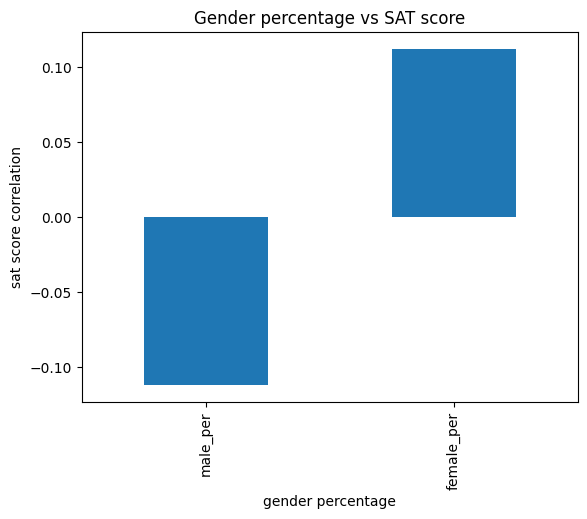

In [23]:
gender_sat = combined[["male_per","female_per","sat_score"]]
gender_sat_corr = gender_sat.corr()["sat_score"][:-1]
gender_sat_corr.plot.bar()
plt.title("Gender percentage vs SAT score")
plt.ylabel("sat score correlation")
plt.xlabel("gender percentage")
plt.show()

From the above graph, we can see that woman tend correlate with a higher sat score, whilst men a lower sat score. Let us have a further look at schools with a high female percentage and a high SAT score.

In [25]:
high_female_high_sat = combined[(combined["female_per"] > 60) & (combined["sat_score"] > 1600)]
high_female_high_sat

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist,borough
5,01M696,BARD HIGH SCHOOL EARLY COLLEGE,130,624.0,604.0,628.0,1856.0,0,129.028846,197.038462,...,0,0,0.0,0.0,0.0,"525 East Houston Street\nNew York, NY 10002\n(...",40.718962,-73.976066,01,manhattan
26,02M416,ELEANOR ROOSEVELT HIGH SCHOOL,127,572.0,594.0,592.0,1758.0,Eleanor Roosevelt High School,155.000000,235.000000,...,0,0,0.0,0.0,0.0,"411 East 76 Street\nNew York, NY 10021\n(40.77...",40.770116,-73.953379,02,manhattan
27,02M418,MILLENNIUM HIGH SCHOOL,144,528.0,553.0,533.0,1614.0,Millennium High School,86.000000,95.000000,...,0,0,0.0,0.0,0.0,"75 Broad Street\nNew York, NY 10004\n(40.70492...",40.704920,-74.011514,02,manhattan
60,03M479,BEACON HIGH SCHOOL,261,577.0,575.0,592.0,1744.0,BEACON SCHOOL,166.000000,197.000000,...,0,0,0.0,0.0,0.0,"227-243 West 61St Street\nNew York, NY 10023\n...",40.772158,-73.987797,03,manhattan
61,03M485,FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...,531,566.0,564.0,577.0,1707.0,FIORELLO H.LAGUARDIA HS,691.000000,1236.000000,...,0,0,0.0,0.0,0.0,"100 Amsterdam Avenue\nNew York, NY 10023\n(40....",40.773671,-73.985269,03,manhattan
287,24Q299,BARD HIGH SCHOOL EARLY COLLEGE II,155,545.0,568.0,550.0,1663.0,0,129.028846,197.038462,...,0,0,0.0,0.0,0.0,"30-20 Thomson Avenue\nLong Island City, NY 111...",40.745094,-73.936814,24,queens
302,25Q525,TOWNSEND HARRIS HIGH SCHOOL,278,621.0,651.0,638.0,1910.0,TOWNSEND HARRIS HS,613.000000,796.000000,...,0,0,0.0,0.0,0.0,"149-11 Melbourne Avenue\nFlushing, NY 11367\n(...",40.734408,-73.821417,25,queens


A lot of high schools with a lot more girls and a high sat score are college prep high schools

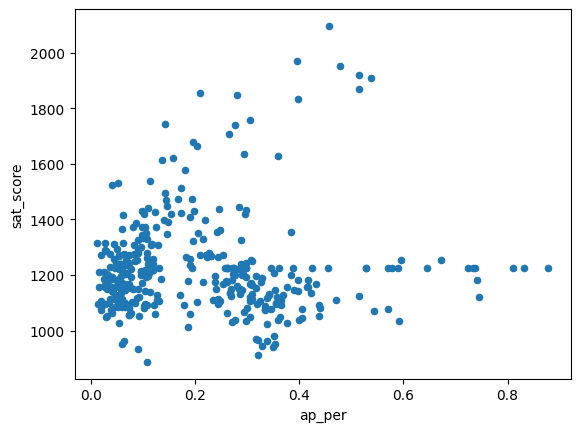

In [61]:
combined["ap_per"] = combined["AP Test Takers "] / combined["total_enrollment"]

combined.plot.scatter(x = "ap_per" , y = "sat_score")
plt.show()

Looking at the above graph, we can see that when over 50% of students take the SAT test,  the average SAT score doesn't rise above 1300. This might suggest that students who are not ready to take them test are encouraged to take it.

## Part 6: Discussion and conclusion

Looking over the data, we can see that there are many factors which may increase, or decrease SAT scores for a school. For college prep and other advanced schools which have a higher SAT score, we can conclude that SAT scores are working as intended. As students are more likely  to academically gifted in these schools, it would make sense that SAT scores would be higher.

In schools with lower SAT scores, some of them are catered towards students who are still learning English as a second or third language. Because of this, the SAT test as it currently is may not be a good measurement of how academically gifted these students are. In this case, it would make sense to create a similar test system writtern in Spanish, Americas most common second language. By writing in a language they have already learned, it would be much easier to discern how academically gifted a student may be.

However, this is not the only obstacle to a good SAT score. Many districts which have the lowest SAT scores are also the poorest, which shows that income inequality has a significant impact on SAT score, which has a further impact on earnings if students do not get a high enough score to get to esteemed universities. This is further compounded by safety being a key issue in these schools. This is a complex issue, and not something that can easily by resolved by changing the SAT system. The focus on these communities, outside of easing income disparity, would be to make sure that schools are safe spaces to learn and teach in.

Looking and racial and gender dynamics, we can also see a significant difference in SAT scores. Black and hispanic communities were more likely to have poor SAT scores, whilst white and asian communities likely to be higher. This may be due to black and hispanic communities being historically being targeted by racist policies. With segregation being overturned in 1964, and racism still being an issue, these communities are more likely to be underfunded and sidelined. Again, this is a complex issue, and cannot be reasonably solved by changing the SAT test system.

Finally, we can also see that men are less likely to do well on SAT scores. This may be because men are more likely to be encouraged to go into vocational roles, whilst there's a stronger push for women to go to University. To combat this, we need to keep vocational and academic routes open for men and women as they deem fit to choose.

In conclusion, the issues surrounding the SAT system go much deeper than the system itself. Changing how the SA

